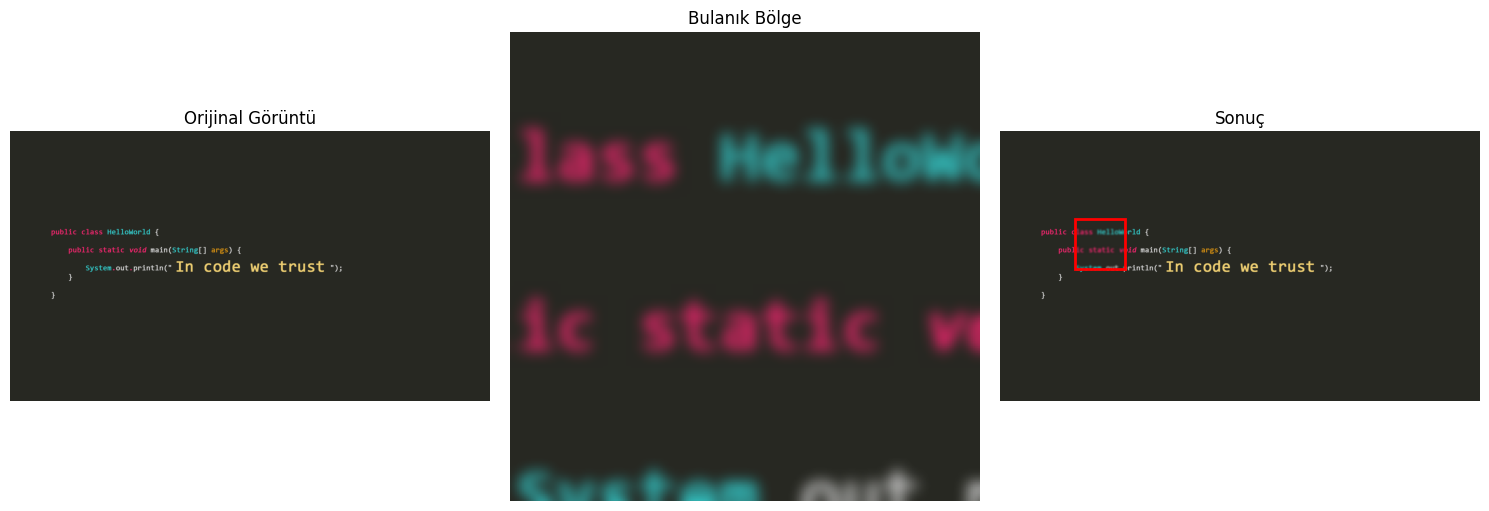

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

def gaussian_kernel(size, sigma):
    """
    2B Gaussian kerneli oluştur
    """
    if size % 2 == 0:
        size += 1
    
    center = size // 2
    
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x**2 + y**2)/(2*sigma**2))
    
    return kernel / np.sum(kernel)

def manuel_konvolusyon(goruntu, kernel):
    if len(goruntu.shape) == 3:
        h, w, c = goruntu.shape
    else:
        h, w = goruntu.shape
        c = 1
        goruntu = goruntu.reshape(h, w, 1)
    
    k_h, k_w = kernel.shape
    pad_h = k_h // 2
    pad_w = k_w // 2
    
    padded = np.pad(goruntu, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='edge')
    
    cikti = np.zeros_like(goruntu, dtype=np.float32)
    
    for y in range(h):
        for x in range(w):
            for ch in range(c):
                pencere = padded[y:y+k_h, x:x+k_w, ch]
                cikti[y, x, ch] = np.sum(pencere * kernel)
    
    # Değerleri 0-255 aralığına normalize et
    cikti = np.clip(cikti, 0, 255)
    return cikti.astype(np.uint8)

def bolge_bulaniklastir(goruntu_yolu, bolge_koordinat, kernel_boyut=5, sigma=2.0, max_boyut=4000):
    try:
        if not os.path.exists(goruntu_yolu):
            raise FileNotFoundError(f"Hata: {goruntu_yolu} dosyası bulunamadı.")

        with Image.open(goruntu_yolu) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
                
            # Boyut kontrolü
            if img.size[0] > max_boyut or img.size[1] > max_boyut:
                oran = max_boyut / max(img.size)
                yeni_boyut = tuple(int(boyut * oran) for boyut in img.size)
                img = img.resize(yeni_boyut, Image.LANCZOS)
            
            goruntu_array = np.array(img)

        x1, y1, x2, y2 = bolge_koordinat
        
        h, w = goruntu_array.shape[:2]
            
        if x1 < 0 or y1 < 0 or x2 > w or y2 > h:
            raise ValueError(f"Geçersiz koordinatlar! Görüntü boyutu: {w}x{h}")

        kernel = gaussian_kernel(kernel_boyut, sigma)
        
        sonuc_goruntu = goruntu_array.copy()
        
        bolge = goruntu_array[y1:y2, x1:x2].copy()
        
        bulanik_bolge = manuel_konvolusyon(bolge, kernel)
        
        sonuc_goruntu[y1:y2, x1:x2] = bulanik_bolge

        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.title("Orijinal Görüntü")
        plt.imshow(goruntu_array)
        plt.axis("off")
        
        # Sadece bulanık bölge
        plt.subplot(132)
        plt.title("Bulanık Bölge")
        plt.imshow(bulanik_bolge)
        plt.axis("off")

        # Son görüntü
        plt.subplot(133)
        plt.title("Sonuç")
        plt.imshow(sonuc_goruntu)
        dikdortgen = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(dikdortgen)
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

        return sonuc_goruntu

    except Exception as e:
        print(f"Hata oluştu: {str(e)}")
        return None

if __name__ == "__main__":
    goruntu_yolu = "./aYLes3-3172827765.png"
    bolge_koordinat = (300, 350, 500, 550)
    kernel_boyut = 15
    sigma = 3.0  
    bulanik_goruntu = bolge_bulaniklastir(
        goruntu_yolu=goruntu_yolu,
        bolge_koordinat=bolge_koordinat,
        kernel_boyut=kernel_boyut,
        sigma=sigma,
        max_boyut=4000
    )